<a href="https://colab.research.google.com/github/Faig22/Neural_Collaborative_Filtering/blob/main/Rec_sys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание от VK

Необходимо реализовать рекомендательную систему на нейросетевом подходе. Я попробую реализовать в этом ноутбуке ***Neural Collaborative Filtering*** (***NCF***). 

Этот подход основан на сравнении пользователей между собой с точки зрения оценок просмотренных фильмов, и далее предсказании оценки фильма, который заинтересует данного пользователя на основании того, что похожие на него пользователи смотрели этот фильм.

## Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pytorch_lightning as pl

from tqdm.notebook import tqdm

In [ ]:
# pip install pytorch_lightning

## Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

with ZipFile("drive/MyDrive/Deep Learning projects/Тестовые/VK/ml-latest.zip") as myzip:
    movie = myzip.open("ml-latest/movies.csv")
    ratings = myzip.open("ml-latest/ratings.csv")
      
movies = pd.read_csv(movie)
ratings = pd.read_csv(ratings)

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


## Разведочный анализ данных

In [ ]:
print(f"Размер таблицы movies: {movies.shape}")
print(f"Размер таблицы ratings:{ratings.shape}")
print(30*'--')
print(f'Кол-во уникальных фильмов: {ratings.movieId.nunique()}')
print(f'Кол-во уникальных пользователей: {ratings.userId.nunique()}')

Размер таблицы movies: (58098, 3)
Размер таблицы ratings:(27753444, 4)
------------------------------------------------------------
Кол-во уникальных фильмов: 53889
Кол-во уникальных пользователей: 283228
283228


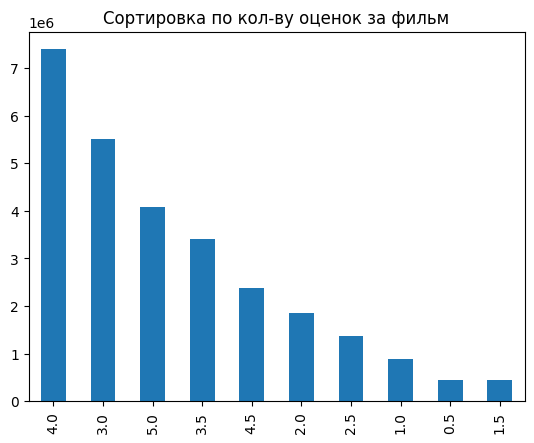

In [ ]:
ratings.rating.value_counts().plot(kind='bar', title='Сортировка по кол-ву оценок за фильм')
plt.show()

Высоких оценок предостаточно 

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


Пропусков в таблице ***movies*** нет

In [ ]:
missing_train = (ratings.isnull().sum() / ratings.shape[0] * 100).sort_values(ascending=False)
missing_train = missing_train[missing_train > 0]
missing_train

Series([], dtype: float64)

В ***ratings*** пропусков тоже нет

In [ ]:
genres = movies['genres'].values
genres = [genre.split('|') for genre in genres]

count_genres = {}

for genre in genres:
    for g in genre:
        if g in list(count_genres.keys()):
            count_genres[g] += 1
        else:
            count_genres[g] = 1

count_genres = sorted(count_genres.items(), key=lambda x:x[1], reverse=True)

genres = [genre for genre, cnt in count_genres]
cnt_genres = [cnt for genre, cnt in count_genres]

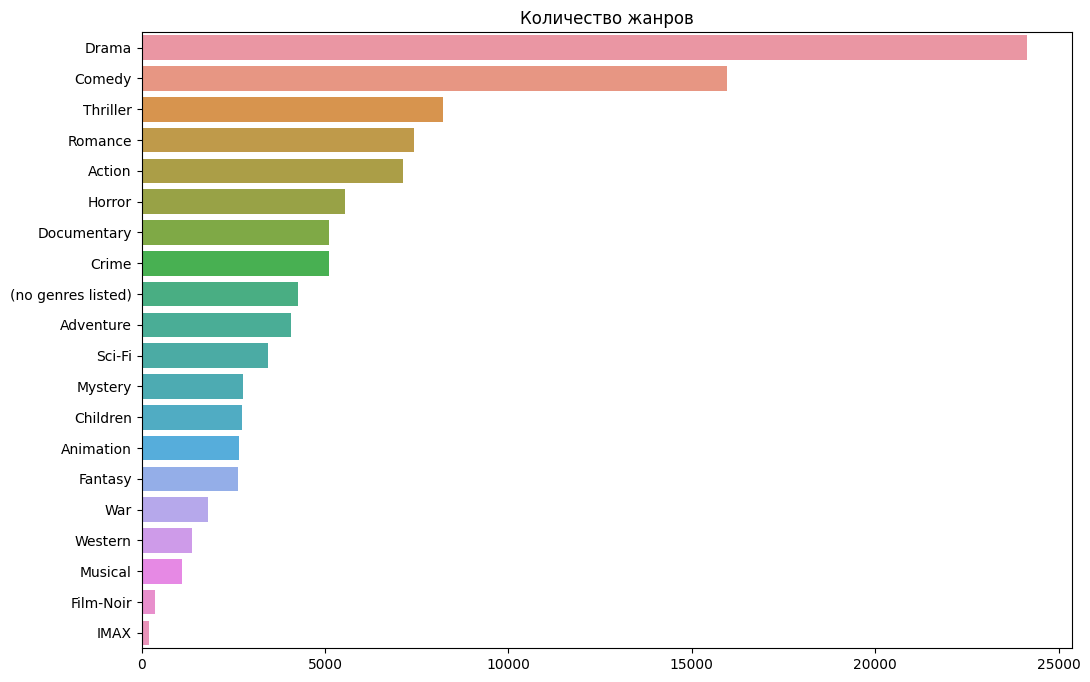

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_genres, y=genres, orient='h').set_title('Количество жанров')
plt.show()

Подавляющее большинство драматических фильмов, а также комедии 

### Разбиение данных на обучение и валидацию

На примере пользователя с ***userId*** = *3* покажем, как разобъем данные на обучение и валидацию.

Отсортируем его данные по времени, когда он поставил оценку

In [ ]:
user = ratings[ratings['userId']==3].sort_values(by='timestamp', ascending=False)
user

,userId,movieId,rating,timestamp
36,3,1645,4.0,945141611
37,3,1825,3.0,945141611
38,3,1985,2.0,945141611
39,3,2024,3.0,945141611
40,3,2028,5.0,945141611
31,3,640,3.0,945141610
32,3,828,4.0,945141610
33,3,960,3.0,945141407
34,3,1221,4.0,945141407
35,3,1321,4.0,945141407


Идея состоит в том, что  у каждого пользователя мы достаем время когда он в последний раз ставил оценку фильму. Эта строчка и пойдет в валидацию. Тем самым мы не рушим временную последовательность в предсказаниях для каждого пользователя 

In [ ]:
user['rank'] = user.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)
user

,userId,movieId,rating,timestamp,rank
36,3,1645,4.0,945141611,1.0
37,3,1825,3.0,945141611,2.0
38,3,1985,2.0,945141611,3.0
39,3,2024,3.0,945141611,4.0
40,3,2028,5.0,945141611,5.0
31,3,640,3.0,945141610,6.0
32,3,828,4.0,945141610,7.0
33,3,960,3.0,945141407,8.0
34,3,1221,4.0,945141407,9.0
35,3,1321,4.0,945141407,10.0


Реализуем это с помощью функции ***rank***, в параметрах укажем метод ***first*** и отсортируем по убыванию, тем самым мы награждаем единицой самое позднее время когда пользователь оценил фильм. Все строчки с ***rank*** = *1* пойдут на валидацию, все остальное на обучение  

In [ ]:
ratings['rank'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [ ]:
train_ratings = ratings[ratings['rank'] != 1]
test_ratings = ratings[ratings['rank'] == 1]

train_ratings = train_ratings.drop(columns=['rank'])
test_ratings = test_ratings.drop(columns=['rank'])

In [ ]:
print(f'Размер обучающих данных {train_ratings.shape}')
print(f'Размер валидационных данных {test_ratings.shape}')

Размер обучающих данных (27470216, 4)
Размер валидационных данных (283228, 4)


## Создание датасета

Представим задачу в виде бинарной классификации. Если пользователь поставил оценку ниже *3*, то будем считать что фильм не понравился (***label*** = *0*), если выше, то (***label*** = *1*)

Создадим класс кастомного датасета, который наследуется от ***torch.utils.data.Dataset*** 

In [ ]:
class MovieLens(Dataset):
  def __init__(self, data, threshold):
      self.users, self.items, self.labels = self.get_dataset(data, threshold)
  
  def __len__(self):
      return len(self.users)
  
  def __getitem__(self, idx):
     return self.users[idx], self.items[idx], self.labels[idx]

  def get_dataset(self, data, threshold):
      users = []
      items = []
      labels = []

      for user, item, rating in set(zip(data['userId'], data['movieId'], data['rating'])):
          users.append(user)
          items.append(item)
          labels.append(float(rating/5 > threshold))

      return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

In [ ]:
train_set = MovieLens(data=train_ratings, threshold=0.5)
test_set = MovieLens(data=test_ratings, threshold=0.5)

In [ ]:
train_set = torch.save(train_set, 'train_set.pt')
test_set = torch.save(test_set, 'test_set.pt')


In [ ]:
# train_data = DataLoader(train_set, batch_size=512, num_workers=1)

# for sample in train_data:
#     print(sample[0].shape)
#     print(sample[1].shape)
#     print(sample[2].shape)
#     break

torch.Size([512])
torch.Size([512])
torch.Size([512])


## Разработка архитектуры нейронной сети

Эмбеддинги - это векторные представления слов. Логика заключается в том, что у похожих слов векторы должны не сильно различаться. То есть у пользователей, которые посмотрели одни и те же фильмы, расстояния между векторами должно быть минимальным. Также и с похожими фильмами.

На вход нашей модели подадим эмбеддинги пользователей и фильмов. Далее мы их сконкатенируем, а после пропустим через два линейных слоя. В конце первого слоя будет стоять функция активации ***LeakyRelu***, а в конце модели сигмоида, которая даст вероятность того, что фильм может понравиться пользователю (*1*) или нет (*0*)

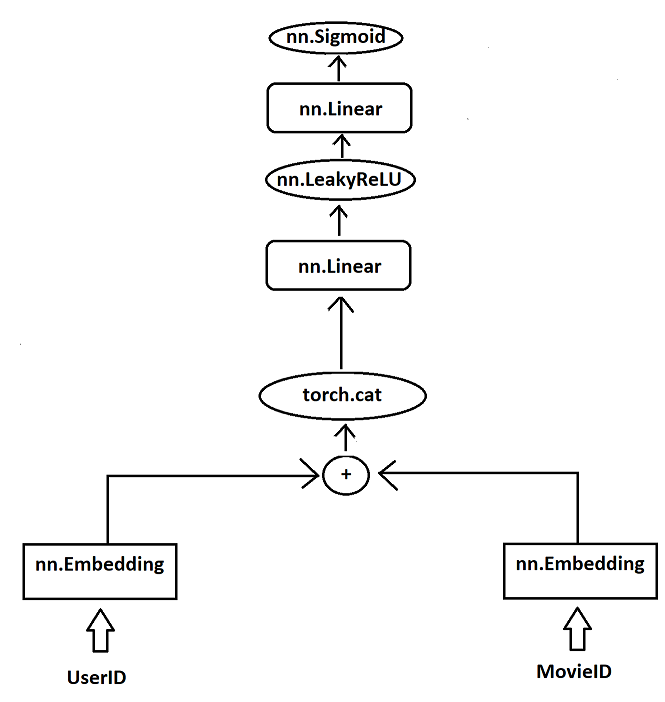

Напишем модель нашей сети через библиотеку ***pytorch lightning***

In [ ]:
class RecSysNetwork(pl.LightningModule):
    def __init__(self, n_users, n_items,train_set, test_set, embedding_dim = 16):
        super().__init__()

        self.users_embedding = nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.items_embedding = nn.Embedding(num_embeddings=n_items, embedding_dim=embedding_dim)
        
        self.linear1 = nn.Linear(embedding_dim*2, 16)
        self.linear2 = nn.Linear(16, 1)

        self.act1 = nn.LeakyReLU()
        self.act2 = nn.Sigmoid()

        self.loss_fn = nn.BCELoss()

        self.train_set = train_set
        self.test_set = test_set

        self.save_hyperparameters(logger=False)


    def forward(self, users, items):

        users_embedding = self.users_embedding(users)
        items_embedding = self.items_embedding(items)
        
        out = torch.cat([users_embedding, items_embedding], dim=-1)

        out = self.linear1(out)
        out = self.act1(out)

        out = self.linear2(out)
        out = self.act2(out)

        return out

    def configure_optimizers(self):
    
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step (self, batch, batch_idx):
        
        users, items, labels = batch
        pred = self(users, items)
        
        loss = self.loss_fn(pred, labels.view(-1, 1).float())
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):

        users, items, labels = batch
        pred = self.forward(users, items)
        
        loss = self.loss_fn(pred, labels.view(-1, 1).float())
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=512, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.test_set, batch_size=512, num_workers=1)


### Обучение

Обучим модель и сразу же сохраним к себе на диск его веса

In [ ]:
n_users = ratings.userId.max() + 1
n_items = ratings['movieId'].max() +1

PATH_to_save = f"/content/drive/My Drive/My_save_models/RecSysNetwork/checkpoint"

model = RecSysNetwork(n_users=n_users,
                      n_items=n_items, 
                      train_set = train_set,
                      test_set = test_set)

trainer = pl.Trainer(accelerator='cuda', max_epochs=5,
                      default_root_dir=PATH_to_save)
trainer.fit(model)
trainer.validate(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type      | Params
----------------------------------------------
0 | users_embedding | Embedding | 4.5 M 
1 | items_embedding | Embedding | 3.1 M 
2 | linear1         | Linear    | 528   
3 | linear2         | Linear    | 17    
4 | act1            | LeakyReLU | 0     
5 | act2            | Sigmoid   | 0     
6 | loss_fn         | BCELoss   | 0     
----------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.538    Total estimated model params siz

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.3764493465423584     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3764493465423584}]

Загрузим веса модели из диска

In [ ]:
import os

PATH_to_load = './drive/MyDrive/My_save_models/RecSysNetwork/checkpoint/lightning_logs/version_0/checkpoints/'
chekpoint_path = os.path.join(PATH_to_load, os.listdir(PATH_to_load)[0])

model = RecSysNetwork.load_from_checkpoint(chekpoint_path, map_location=torch.device('cpu')) # Перевел модель на cpu, т.к. превысил лимит работы с gpu((( 

## Метрика ранжирования

###Hit Ratio @ k

Будем использовать метрику ***Hit Ratio @ k***

Логика ее работы заключается в том, что если среди топ ***k*** предсказаний модели будут фильмы из тестового набора, то значит рекомендация хорошая и метрика равна *1*, если фильмов из тестового набора нет, то предполагается, что рекомендации нам не подойдут и метрика будет равна *0*. Далее считается среднее из набора *1* и *0*. И это будет итоговая метрика модели. 

Но можно эту метрику модифицировать. Моя модель предсказывает фильмы, которые могут понравиться пользователю, а ***Hit Ratio @ k*** по умолчанию предполагает, что просмотренные фильмы понравились пользователю. 

К примеру, представим, что пользователю не понравился последний просмотренный фильм и он поставил ему низкую оценку. Если модель в топ *k* рекомендациях высветит этот фильм, то метрика будет равна 1, что по сути является недочетом.

Поэтому мы немного усложним ***Hit Ratio @ k***, он будет давать единицу в двух случаях: 


1.   Фильм из тестового набора понравился и он попал в рекомендацию 
2.   Фильм из тестового набора не понравился и он не попал в рекомендацию 

В остальных случаях ***Hit Ratio @ k***=0



In [ ]:
test_set = set(zip(test_ratings['userId'], test_ratings['movieId']))
user_watch_films = ratings.groupby(['userId'])['movieId'].apply(list).to_dict()
all_movies = ratings['movieId'].unique()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def hit_ratio_k(k:int, model, movies, ratings, test_data, threshold:int):
    
    hits = []
    model = model.to(device)

    for (user, item) in test_data:
        not_watch_films = set(movies) - set(user_watch_films[user])
        not_watch_films = np.random.choice(list(not_watch_films), 99)
        rating = ratings[(ratings['userId'] == user) & 
                        (ratings['movieId'] == item)]\
                          ['rating'].values[0]

        test_items = list(not_watch_films) + [item]
        pred = np.squeeze(model(torch.tensor([user]*100).to(device),
                                torch.tensor(test_items).to(device))\
                                .cpu().detach().numpy())
        
        top_k_films = [test_items[i] for i in np.argsort(pred)[::-1][0:k].tolist()]

        if (rating / 5 > threshold) and (item in top_k_films):
            hits.append(1)
        
        elif (rating / 5 < threshold) and (item not in top_k_films):
            hits.append(1)
        
        else:
            hits.append(0)
        
    return f"Hit ratio @ {k} = {np.mean(hits)}"
     

In [ ]:
hit_ratio_k(k=10, model=model,
            movies=all_movies,
            ratings=ratings,
            test_data=test_set,
            threshold=0.5)

'Hit ratio @ 10 = 0.478'

Есть куда расти!)